# Celeb-DF-v2 Dataset Sampling


This notebook is used to sample the full [Celeb-DF-v2](https://github.com/yuezunli/celeb-deepfakeforensics) dataset for deepfake detection research purposes. Sample data of 100 deepfakes and 100 real videos are extracted to be 100 frames for each video, resulting in a total of 20,000 frames of image.


In [1]:
import os
import re
import csv
import random
import shutil
import cv2
import matplotlib.pyplot as plt

In [63]:
DATASET_DIR = "/mnt/e/datasets/Celeb-DF-v2"
YOUTUBE_REAL_DIR = os.path.join(DATASET_DIR, "YouTube-real")
CELEB_REAL_DIR = os.path.join(DATASET_DIR, "Celeb-real")
CELEB_SYNTHESIS_DIR = os.path.join(DATASET_DIR, "Celeb-synthesis")

SAMPLE_DIR = "/mnt/e/samples/vids/Celeb-DF-v2"
SAMPLE_DEEPFAKE_DIR = os.path.join(SAMPLE_DIR, "Deepfake")
SAMPLE_REAL_VID_DIR = os.path.join(SAMPLE_DIR, "Real")

SAMPLE_FRAMES_DIR = "/mnt/e/samples/extracted/Celeb-DF-v2"
SAMPLE_FRAMES_DEEPFAKE_DIR = os.path.join(SAMPLE_FRAMES_DIR, "Deepfake")
SAMPLE_FRAMES_REAL_VID_DIR = os.path.join(SAMPLE_FRAMES_DIR, "Real")

SAMPLE_LIST_PATH = "celeb-df-v2-list.csv"

SAMPLE_SIZE = 100
EXTRACTED_FRAME_SIZE = 100

## Sample 100 Deepfakes & 100 Real Vids


In [24]:
sample_deepfake_files = []
sample_real_vid_files = []

### Sample Deepfakes Proportionally


In [25]:
deepfake_files = os.listdir(CELEB_SYNTHESIS_DIR)
sample_deepfake_files_gap = round(len(deepfake_files) / SAMPLE_SIZE)

In [26]:
for i, filename in enumerate(deepfake_files):
    if (i != 0) and (i % sample_deepfake_files_gap == 0):
        sample_deepfake_files.append(f"{CELEB_SYNTHESIS_DIR}/{filename}")

print(f"Sampled {len(sample_deepfake_files)} deepfakes")

Sampled 100 deepfakes


### Sample Real Vids (Each for Celeb Id)


In [30]:
celeb_real_vid_files = os.listdir(CELEB_REAL_DIR)
celeb_ids = set([filename.split("_")[0] for filename in celeb_real_vid_files])

In [31]:
for celeb_id in celeb_ids:
    regex_pattern = f"{celeb_id}_"
    celeb_id_real_vid_files = [
        filename
        for filename in celeb_real_vid_files
        if re.match(regex_pattern, filename)
    ]
    random_vid_index = random.randint(0, len(celeb_id_real_vid_files) - 1)
    sample_real_vid_files.append(
        f"{CELEB_REAL_DIR}/{celeb_id_real_vid_files[random_vid_index]}"
    )

print(f"Sampled {len(sample_real_vid_files)} real vids")

Sampled 59 real vids


### Add Additional YouTube Real Vids


In [32]:
youtube_real_vid_files = os.listdir(YOUTUBE_REAL_DIR)
num_additional_real_vids = SAMPLE_SIZE - len(sample_real_vid_files)

In [33]:
additional_real_vids = random.sample(youtube_real_vid_files, num_additional_real_vids)
sample_real_vid_files.extend(
    [f"{YOUTUBE_REAL_DIR}/{filename}" for filename in additional_real_vids]
)

print(f"Added {num_additional_real_vids} additional real vids to sample")
print(f"Sampled {len(sample_real_vid_files)} real vids in total")

Added 41 additional real vids to sample
Sampled 100 real vids in total


### Copy Sample to a Separate Directory


In [34]:
for file_path in sample_deepfake_files:
    if os.path.isfile(file_path):
        shutil.copy(file_path, SAMPLE_DEEPFAKE_DIR)

In [35]:
for file_path in sample_real_vid_files:
    if os.path.isfile(file_path):
        shutil.copy(file_path, SAMPLE_REAL_VID_DIR)

### Create CSV File to List Sample Video Files


In [55]:
with open(SAMPLE_LIST_PATH, "w", newline="") as sample_list_file:
    header = ["file", "label"]
    writer = csv.writer(sample_list_file)
    writer.writerow(header)

    for filename in sample_deepfake_files:
        dataset_path = filename.split("/")[-3:]
        writer.writerow(["/".join(dataset_path), "deepfake"])

    for filename in sample_real_vid_files:
        dataset_path = filename.split("/")[-3:]
        writer.writerow(["/".join(dataset_path), "real"])

## Extract Sample Video Frames


### Extract Deepfakes and Real Vids Frames


In [100]:
def extract_frames(video_path, output_dir, num_frames=100):
    cap = cv2.VideoCapture(video_path)

    num_frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if num_frames_total <= num_frames:
        frame_interval = 1
    else:
        frame_interval = int(num_frames_total / num_frames)

    frames = []
    count = 1

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        if count % frame_interval == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
            filename, _ = os.path.splitext(video_path)
            filename = filename.split("/")[-1]
            frame_count = int(count / frame_interval)
            cv2.imwrite(
                os.path.join(output_dir, f"{filename}-{frame_count}.jpg"),
                frame,
            )

            if frame_count == 100:
                break

        count += 1

    cap.release()

In [112]:
for filename in os.listdir(SAMPLE_DEEPFAKE_DIR):
    file_path = os.path.join(SAMPLE_DEEPFAKE_DIR, filename)
    extract_frames(file_path, SAMPLE_FRAMES_DEEPFAKE_DIR)

In [118]:
for filename in os.listdir(SAMPLE_REAL_VID_DIR):
    file_path = os.path.join(SAMPLE_REAL_VID_DIR, filename)
    extract_frames(file_path, SAMPLE_FRAMES_REAL_VID_DIR)

### Preview Extracted Video Frames


In [13]:
NUM_PREVIEW_IMAGES = 20
NUM_ROWS = 5
NUM_COLS = NUM_PREVIEW_IMAGES // NUM_ROWS

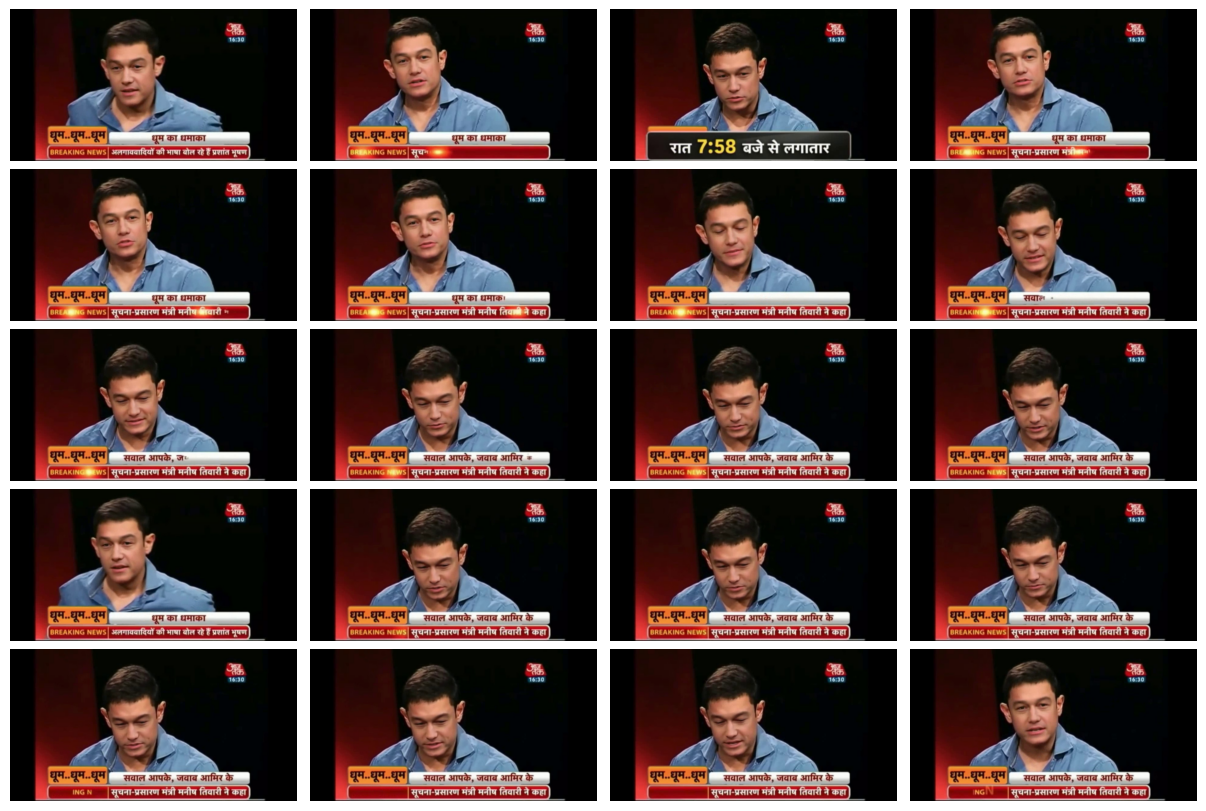

In [39]:
frame_files = [
    os.path.join(SAMPLE_DEEPFAKE_DIR, filename)
    for filename in os.listdir(SAMPLE_DEEPFAKE_DIR)[:NUM_PREVIEW_IMAGES]
]

fig, axs = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(12, 8), constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    img = plt.imread(frame_files[i])
    ax.imshow(img)
    ax.axis("off")

plt.show()